In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns


print('Tensorflow Version {}'.format(tf.__version__))

Tensorflow Version 2.4.1


# 1. Data Preprocessing 

In [3]:
import pandas as pd

train_dataset = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_dataset = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print('Total size of the train dataset is {}'.format(train_dataset.shape))
print('Total size of the test dataset is {}'.format(test_dataset.shape))

Total size of the train dataset is (42000, 785)
Total size of the test dataset is (28000, 784)


In [4]:
y_train = train_dataset['label']

X_train = train_dataset.drop(['label'], axis=1)


print('Size of X_train {}'.format(X_train.shape))
print('Size of y_train {}'.format(y_train.shape))

Size of X_train (42000, 784)
Size of y_train (42000,)


# 1.2 Missing Values

In [5]:
train_dataset.isna().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [6]:
test_dataset.isna().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# 1.3 Normalizing and Reshaping

In [7]:
# Normalization of the data
X_train = X_train/255.0
test_dataset = test_dataset/255.0

In [8]:
# Reshaping of the dataset
X_train = X_train.values.reshape(-1, 28, 28, 1)
test_dataset = test_dataset.values.reshape(-1,28,28,1)

print('Shape of the train dataset is {}'.format(X_train.shape))
print('Shape of the test dataset is {}'.format(test_dataset.shape))

Shape of the train dataset is (42000, 28, 28, 1)
Shape of the test dataset is (28000, 28, 28, 1)


# 1.4 One-Hot-Encoding

One hot encoding of label feature

In [9]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)

print('Shape of y_train after one hot encoding {}'.format(y_train.shape))


Shape of y_train after one hot encoding (42000, 10)


# 2. Train and Test Split

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True, test_size=0.2)

print('Size of train dataset is {}'.format(x_train.shape))
print('Size of the val dataset is {}'.format(x_val.shape))

Size of train dataset is (33600, 28, 28, 1)
Size of the val dataset is (8400, 28, 28, 1)


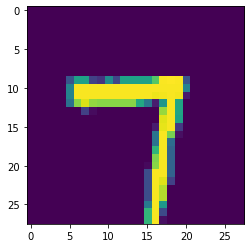

In [11]:
#visulaization of training set
import random
i = random.randint(10,5000)
plt.imshow(x_train[i][:,:,0])
    

# 3. CNN Sequential Model

In [12]:
# setting up model parameters
input_shape = (28,28,1)
batch_size = 64
num_classes = y_train.shape[1]
epochs = 20

In [13]:
# CNN model

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding ='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding ='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax')   
    
])

model.compile (optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# creating a callback for 99.55% accuracy

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') is not None and logs.get('acc')> 0.995):
            print("\n Reached 99.5% of accuracy!!")
            self.model.stop_training=True
            
callback= myCallback()

# 4. Data Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

datagen.fit(x_train)

In [16]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                  epochs=epochs,
                  validation_data= (x_val, y_val),
                  callbacks = [callback]
                   )   

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
525/525 [==============================] - 17s 24ms/step - loss: 0.7941 - accuracy: 0.7317 - val_loss: 0.0717 - val_accuracy: 0.9785
Epoch 2/20
525/525 [==============================] - 12s 23ms/step - loss: 0.1364 - accuracy: 0.9585 - val_loss: 0.0413 - val_accuracy: 0.9871
Epoch 3/20
525/525 [==============================] - 12s 22ms/step - loss: 0.0979 - accuracy: 0.9710 - val_loss: 0.0437 - val_accuracy: 0.9887
Epoch 4/20
525/525 [==============================] - 12s 22ms/step - loss: 0.0781 - accuracy: 0.9768 - val_loss: 0.0264 - val_accuracy: 0.9924
Epoch 5/20
525/525 [==============================] - 12s 24ms/step - loss: 0.0659 - accuracy: 0.9807 - val_loss: 0.0285 - val_accuracy: 0.9908
Epoch 6/20
525/525 [==============================] - 12s 23ms/step - loss: 0.0580 - accuracy: 0.9818 - val_loss: 0.0342 - val_accuracy: 0.9902
Epoch 7/20
525/525 [==============================] - 12s 23ms/step - loss: 0.0570 - accuracy: 0.9831 - val_loss: 0.0320 - val_accuracy:

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy curve for Training and Validation Dataset')

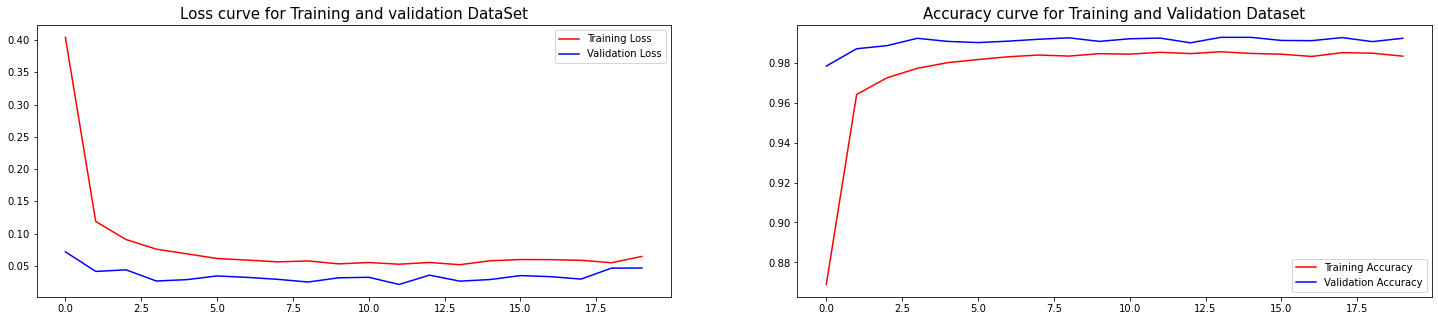

In [18]:
fig, ax = plt.subplots(1,2,figsize=(25,5))

#Loss Curve
ax[0].plot(history.history['loss'], color='r', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='b', label='Validation Loss')
ax[0].legend(loc='best')
ax[0].set_title('Loss curve for Training and validation DataSet', color='k', size=15)

#Accuracy Curve
ax[1].plot(history.history['accuracy'], color='r', label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
ax[1].legend(loc='best')
ax[1].set_title('Accuracy curve for Training and Validation Dataset', size=15)

# 5. Predictions

<AxesSubplot:>

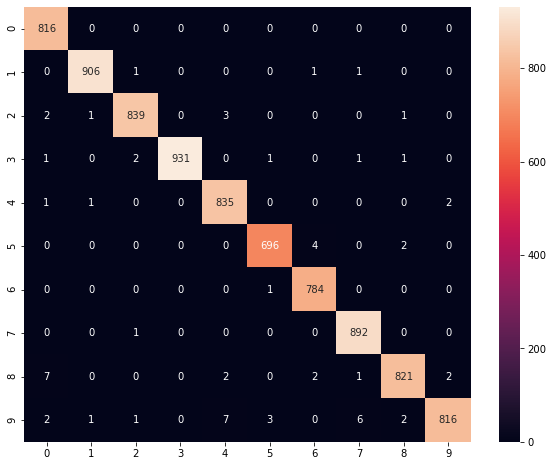

In [19]:
y_val_predict = model.predict(x_val)

y_val_predict_class = np.argmax(y_val_predict, axis=1)


y_val_true_class = np.argmax(y_val, axis=1)


confusion_matrix = tf.math.confusion_matrix(y_val_true_class, y_val_predict_class)


# heatmap for confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix, annot=True, fmt='g')

In [20]:
# predict result of test dataset

predict_test = model.predict(test_dataset)
results = np.argmax(predict_test, axis=1)


print(results)

[2 0 9 ... 3 9 2]


In [21]:
# converting to csv for submission
results = pd.Series(results, name='Label')

final_result = pd.concat([pd.Series(range(1, test_dataset.shape[0]+1), name='ImageId'), results], axis=1)


final_result.to_csv('CNN_digit_classification_TensorFlow.csv', index=False)

If you like this notebook, please upvote!! Happy Learning 